# Importing Libraries

In [104]:
from scipy.linalg import orth
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds,eigs
import matplotlib.pyplot as plt

# Loading the Data

In [105]:
InsA=pd.read_csv('/content/drive/MyDrive/ID5055 assignments/PCA assignment 1/InsA.csv',header=None)
InsB=pd.read_csv('/content/drive/MyDrive/ID5055 assignments/PCA assignment 1/InsB.csv',header=None)
InsC=pd.read_csv('/content/drive/MyDrive/ID5055 assignments/PCA assignment 1/InsC.csv',header=None)
Test=pd.read_csv('/content/drive/MyDrive/ID5055 assignments/PCA assignment 1/Test_data.csv',header=None)

# Denoiser Class

In [106]:
class Denoiser:

  def __init__(self,data,final_dim) :
    self.data=np.array(data)
    self.mean=np.mean(self.data,axis=0)
    self.std=np.std(self.data,axis=0)
    self.dim=final_dim

  #SVD Based
  def get_svs(self) :
    zero_mean=(self.data-self.mean)/self.std
    u,s,v=svds(zero_mean,k=self.dim)
    v=v.T
    return np.fliplr(v)

  #Covariance_matrix Based
  def get_eigvs(self):
    zero_mean=(self.data-self.mean)/self.std
    l=self.data.shape[0]
    cov=(1/l)*((zero_mean.T).dot(zero_mean))
    v,e=eigs(cov,k=self.dim)
    e=np.real(e)
    v=np.real(v)
    return v,e

  def get_dim(self,D,svs=False,eigvs=False):#Get the lower dimensional representation
    Dt=(D-self.mean)/self.std
    if svs==True :
      v=self.get_svs()
      final=Dt.dot(v)
      return final,v
    if eigvs==True :
      v,e=self.get_eigvs()
      final=Dt.dot(e)
      return final,e

  def Reconstruct(self,D,svs=False,eigvs=False) :
    if svs==True:
      Final,v=self.get_dim(D,svs=svs)
    if eigvs==True:
      Final,v=self.get_dim(D,eigvs=eigvs)
    Recons=Final.dot(v.T)*self.std+self.mean
    return Recons

#Scree Plot

In [107]:
def Scree_plot(val,x,data_name):
  val=val/sum(val)
  plt.figure(figsize=(30,10))
  PC=np.arange(1,len(val)+1)
  plt.plot(PC,val,marker='o',color='b',mfc='red')
  plt.xticks(PC,fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("Scree Plot for "+data_name+" data",fontsize=20)
  plt.ylabel('Explained Variance',fontsize=19)
  plt.xlabel('Number of Principal components',fontsize=19)
  plt.axvline(x=x,linestyle='--',color='black')
  plt.axhline(y=val[x-1],linestyle='--',color='black')
  plt.scatter(x,val[x-1],facecolors='none',marker='o',edgecolor='green',s=500,linewidth=3.5,label=f'Optimal Number of PC {x}')
  plt.legend(loc='upper right')
  plt.xlim(0,65.95)
  plt.grid()
  plt.savefig(data_name+'.png')
  plt.show()

#Principal components counter

In [108]:
def PrincipalComponent_counter(variance,thr=0.95):
  s=0
  var=variance/np.sum(variance)
  for i in range(len(variance)):
    if s>=thr:
      idx=i
      break
    s+=var[i]
  return idx,s,var[:idx]

#Exploring the Data

In [109]:
InsA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Columns: 176 entries, 0 to 175
dtypes: float64(176)
memory usage: 123.9 KB


In [110]:
InsB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Columns: 176 entries, 0 to 175
dtypes: float64(176)
memory usage: 123.9 KB


In [111]:
InsC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Columns: 176 entries, 0 to 175
dtypes: float64(176)
memory usage: 123.9 KB


# We will use Eigen Decomposition of Covariance Matrix

#Using 95% variance threshold to pick number of principal components

In [114]:
#Ins A choose the number of components
A=Denoiser(InsA,final_dim=176)
v,e=A.get_eigvs()
number,s,q=PrincipalComponent_counter(v,thr=0.95)
number

4

In [115]:
B=Denoiser(InsB,final_dim=176)
v,e=B.get_eigvs()
number,s,q=PrincipalComponent_counter(v,thr=0.95)
number

61

In [116]:
C=Denoiser(InsC,final_dim=176)
v,e=B.get_eigvs()
number,s,q=PrincipalComponent_counter(v,thr=0.95)
number

61

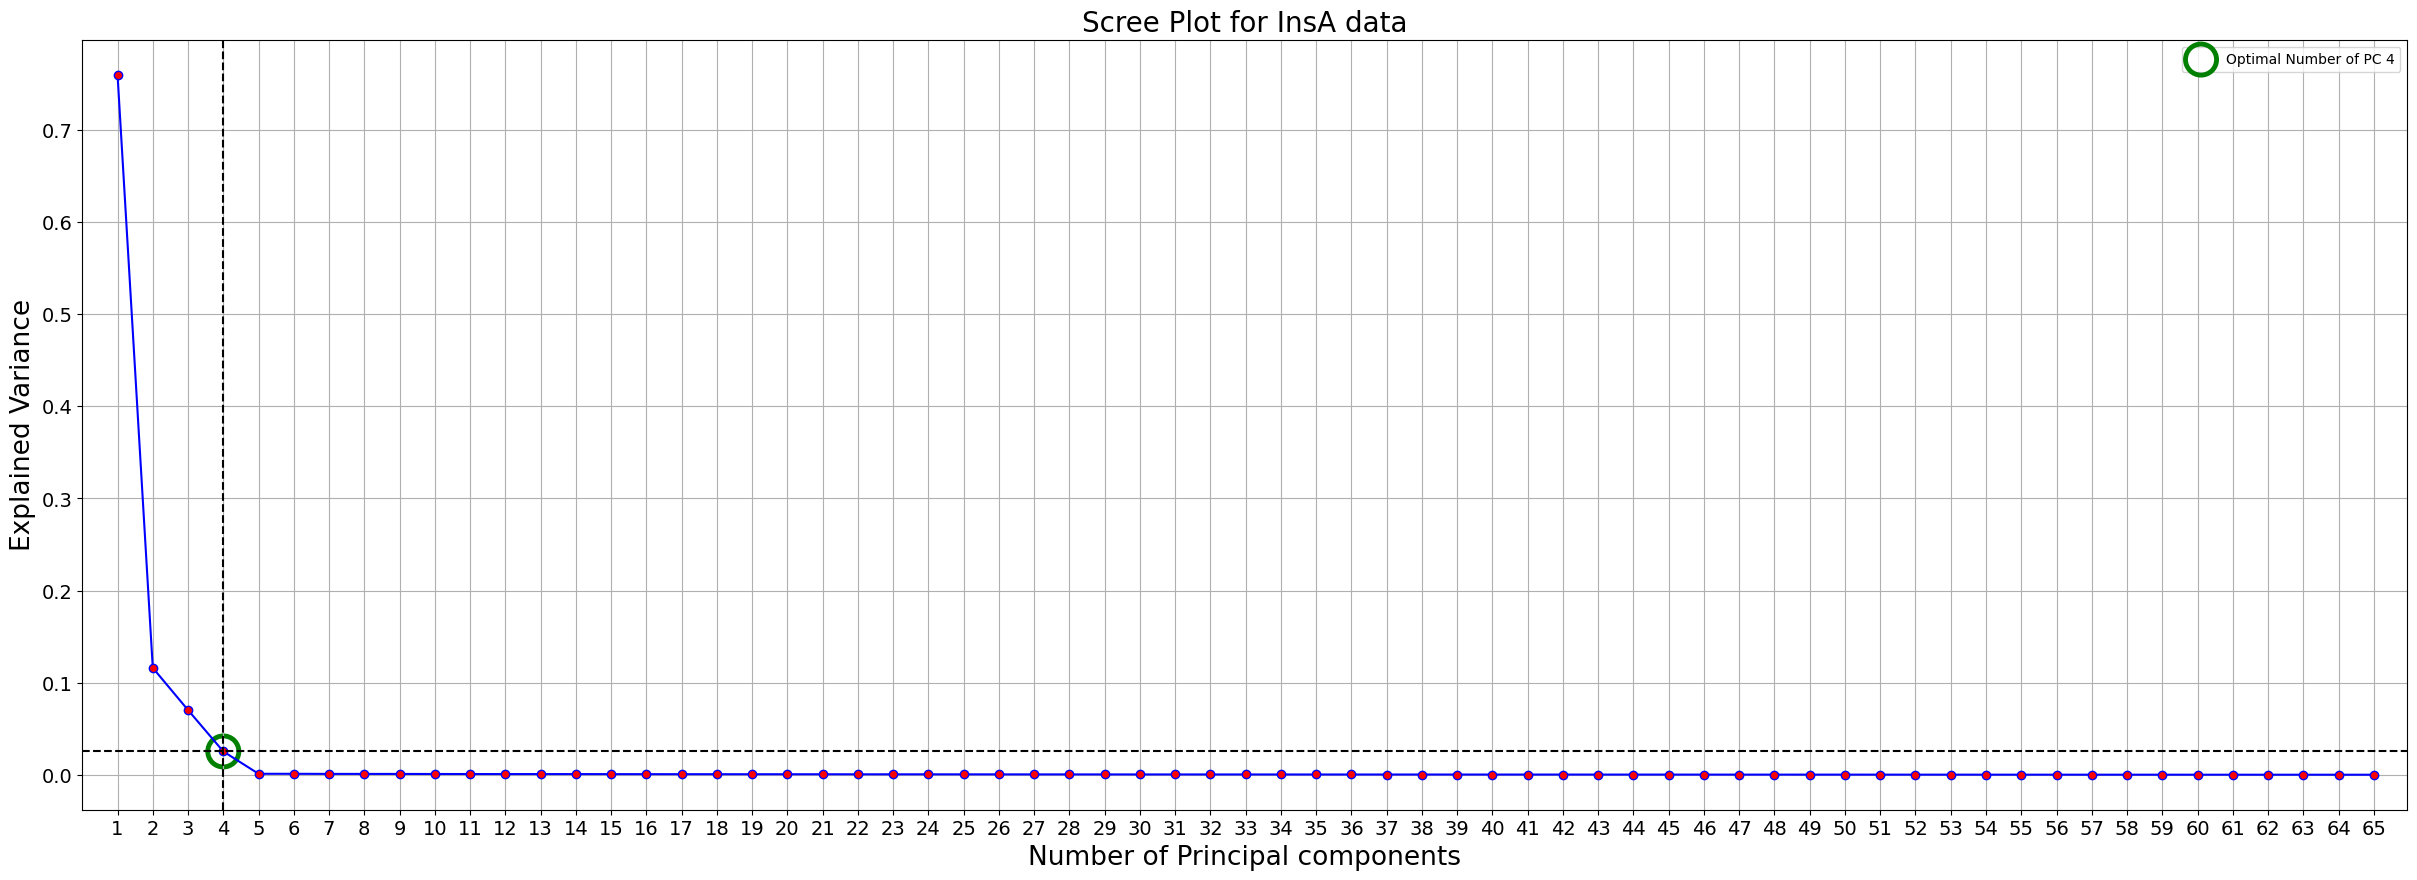

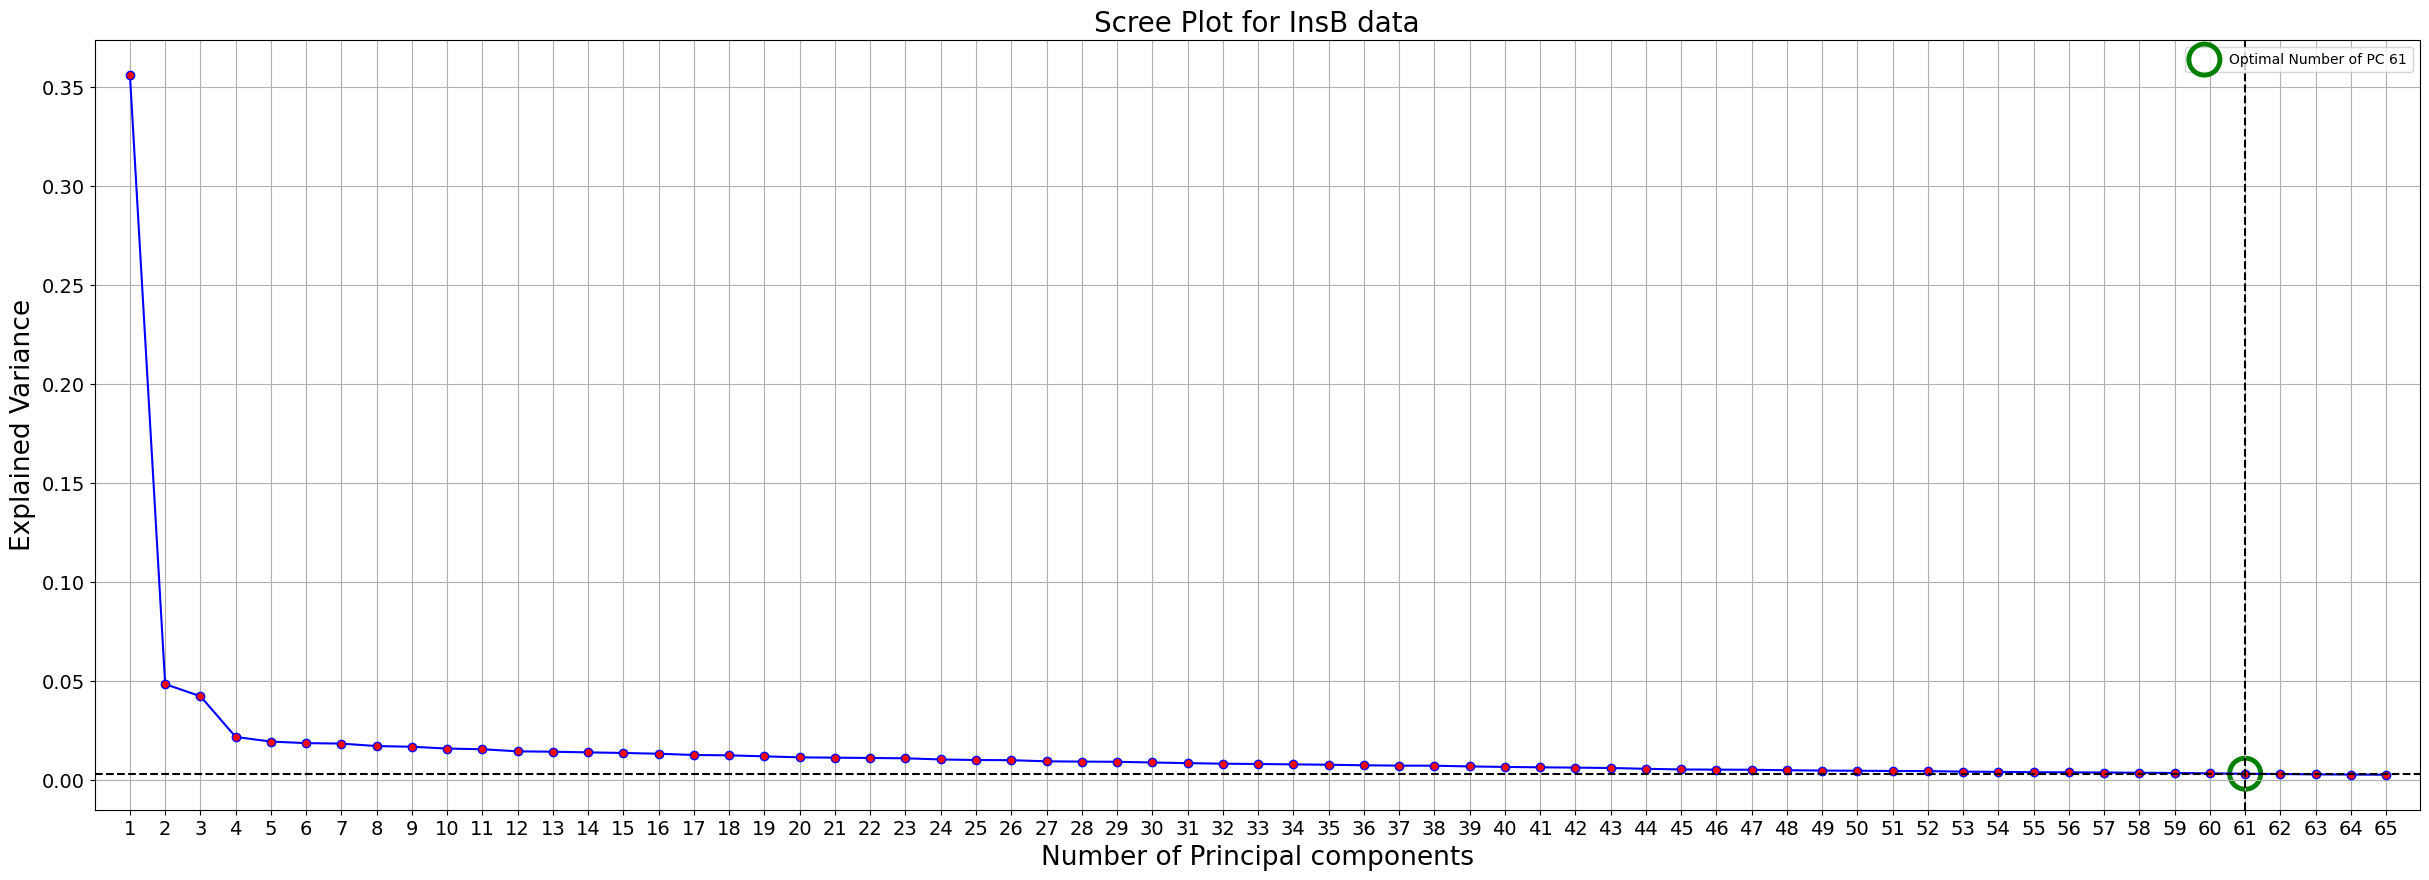

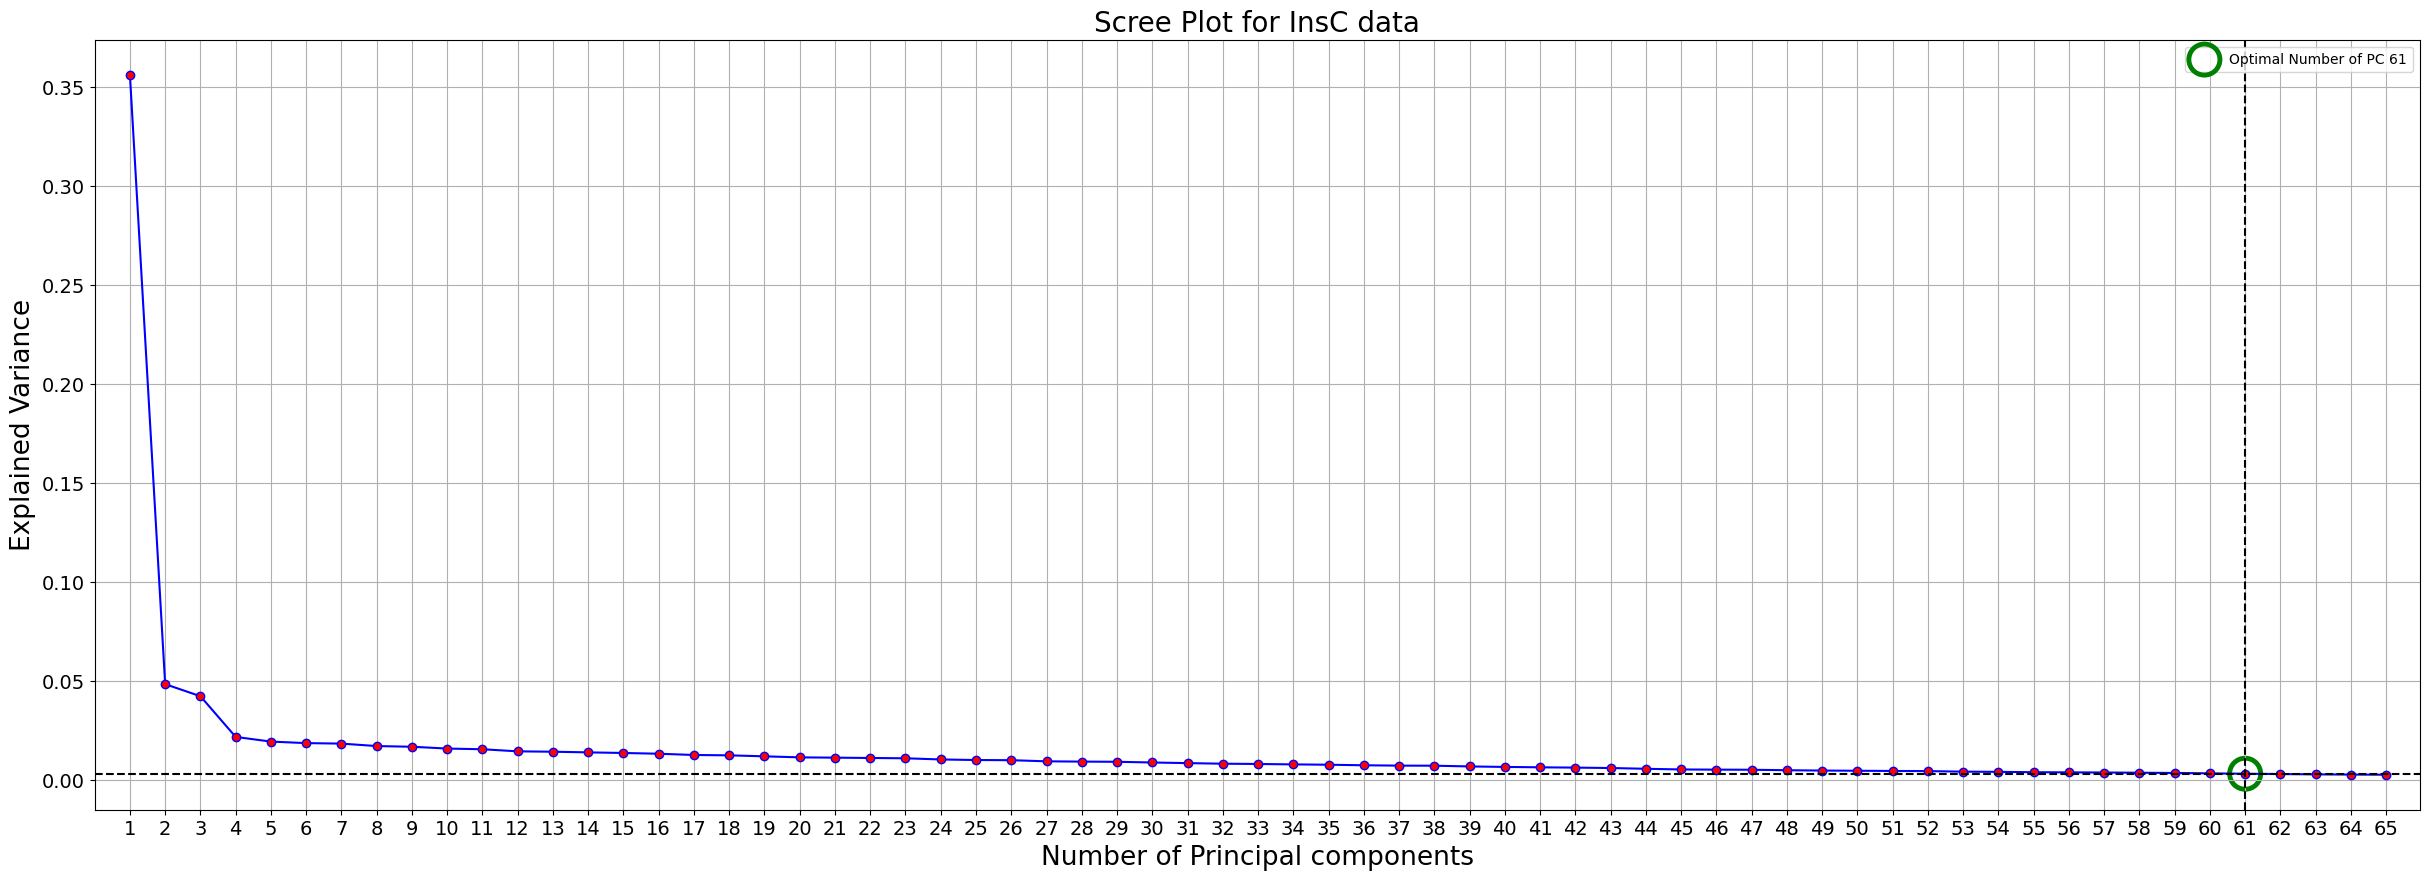

In [117]:
Data=[InsA,InsB,InsC]
PC_no=[4,61,61]
for i,data in enumerate(Data):
  A=Denoiser(data,final_dim=65)#Because the maximum Number of PCs is 61 so we need not show the plot for all the eigenvalues
  v,e=A.get_eigvs()
  Scree_plot(v,PC_no[i],"Ins"+chr(i+65))

In [118]:
A=Denoiser(InsA,final_dim=2)

In [119]:
Test_np=np.array(Test)
Test_rec=A.Reconstruct(Test_np,eigvs=True)

# Anomaly detection on test set

In [120]:
def get_anomaly(orig,recons):
  error=orig-recons
  error_v=np.sum(error**2,axis=1)
  idx=np.argmax(error_v)
  return idx+1,error_v#Add 1 because its zero bases indexing

In [121]:
idx,error=get_anomaly(Test_np,Test_rec)

In [122]:
error

array([ 1.28631401,  3.55028099,  2.70564402,  1.90465194, 51.49424426,
        0.36766391,  1.62487372,  3.56470458,  0.81401525,  1.25725091])

In [123]:
idx

5

We see the reconstruction score is very high for 5th sample. So definitely this contains contaminant
# End of Question 5